Goal of this file: solve for 2D sparse signal.

It seems for sparse signal, the only difference between is in matrix A, in the following cells, the n*n 2D sparse signal is vectorized to form a N=n^2 vector.

One observation: for periodic A as defined below, when $N\rightarrow\infty$, $A^N\rightarrow\frac{1}{N}\vec{1}\vec{1}^T$.

In [ ]:
pip install ipdb

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import cvxpy as cp
import scipy as sp
import scipy.sparse.linalg
from scipy.linalg import circulant
from numpy.linalg import matrix_power
import ipdb
import warnings
import time
warnings.filterwarnings("ignore")

The idea for the dominant step:

$(2\epsilon A^TA+\rho I)x=2\epsilon A^Ty+\rho(z-u),\ A^TA=F\Sigma^2F^H$, i.e.,

$F(2\epsilon\Sigma^2+\rho I)F^Hx=2\epsilon F\Sigma F^Hy+\rho(z-u)$,

$(2\epsilon\Sigma^2+\rho I)F^Hx=2\epsilon \Sigma F^Hy+\rho F^H(z-u)$,

$x=F(2\epsilon\Sigma^2+\rho I)^{-1}(2\epsilon\Sigma F^Hy+\rho F^H(z-u))$

In [1]:
#ADMM for solving min_x ||x||_1 + \epsilon*||y-Ax||^2   st. x>=0  (may not have this constrain)
#here A=F\SigmaF^H
#this function can be used to solve (7) for 1D/2D sparse signal
def myADMM(Sigma,y,constrain=False,maxit=3000,tol=1e-6,epsilon=1e2,rho=50):
  #the choice of rho must be careful!
  N = len(y)
  y = y.reshape(N,)
  err = []
  x = np.random.randn(N,)
  z = np.random.randn(N,)
  u = np.random.randn(N,)
  F = sp.fft.fft(np.eye(N))/np.sqrt(N)
  Fy = sp.fft.fft(y).conjugate()
  d = (2*epsilon*Sigma**2+rho*sp.sparse.eye(N)).diagonal()
  invD = sp.sparse.diags(1/d,0)
  if constrain == True:
    for i in range(maxit):
      #x = np.linalg.solve(2*epsilon*np.dot(A.T,A)+rho*sp.sparse.eye(N),2*epsilon*np.dot(A.T,y)+rho*(z-u))
      #x = np.real(F@(invD@(2*epsilon*Sigma@(F.conjugate()@y)+rho*F.conjugate()@(z-u))))
      #t_0 = time.time()
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*sp.fft.fft(z-u).conjugate())))/N
      #t_1 = time.time()
      #print('time',t_1-t_0)
      z = ((x+u)>(1./rho))*(x+u-1./rho)
      u = u + x - z
      err.append(np.linalg.norm(x-z))
      if i>50 and np.linalg.norm(x-z) < tol:
        print('iter',i)
        break
      #if np.mod(i,10) == 0:
      #  print(i)
  else: 
    for i in range(maxit):
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*sp.fft.fft(z-u).conjugate())))/N
      z = (abs(x+u)>(1./rho))*(abs(x+u)-1./rho)*np.sign(x+u)
      u = u + x - z
      err.append(np.linalg.norm(x-z))
      if i>100 and np.linalg.norm(x-z) < tol:
        print('iter',i)
        break
  return z,err

def makeA2d(n=10,alpha=20):
    s = 1/(2*alpha)
    N = n**2
    A=np.zeros((n**2,n**2))
    A = (1-4*s)*sp.sparse.diags(np.ones((N,)),0) + s*sp.sparse.diags(np.ones((N-1,)),-1) + s*sp.sparse.diags(np.ones((N-1,)),1) \
        + s*sp.sparse.diags(np.ones((N-n,)),n) + s*sp.sparse.diags(np.ones((N-n,)),-n) + s*sp.sparse.diags(np.ones((n,)),N-n) + s*sp.sparse.diags(np.ones((n,)),n-N)
    A[0,-1] = s
    A[-1,0] = s
    return A
    
def psnr1(A,B):
  MSE = torch.mean((A-B)**2)**0.5
  return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)
def psnr2(A,B):
  MSE = np.mean((A-B)**2)**0.5
  return 20*np.log(np.amax(abs(A))/MSE)/np.log(10)

In [34]:
A = makeA2d(3,20)
A.toarray()

array([[0.9  , 0.025, 0.   , 0.025, 0.   , 0.   , 0.025, 0.   , 0.025],
       [0.025, 0.9  , 0.025, 0.   , 0.025, 0.   , 0.   , 0.025, 0.   ],
       [0.   , 0.025, 0.9  , 0.025, 0.   , 0.025, 0.   , 0.   , 0.025],
       [0.025, 0.   , 0.025, 0.9  , 0.025, 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.025, 0.   , 0.025, 0.9  , 0.025, 0.   , 0.025, 0.   ],
       [0.   , 0.   , 0.025, 0.   , 0.025, 0.9  , 0.025, 0.   , 0.025],
       [0.025, 0.   , 0.   , 0.025, 0.   , 0.025, 0.9  , 0.025, 0.   ],
       [0.   , 0.025, 0.   , 0.   , 0.025, 0.   , 0.025, 0.9  , 0.025],
       [0.025, 0.   , 0.025, 0.   , 0.   , 0.025, 0.   , 0.025, 0.9  ]])

In [6]:
#check correctness of the function above, compare with cvx 
def mytest(constraint=False,maxit1=3000,A=[],y=[],epsilon1=1e2,rho1=50):
  if A == []:
    N = 100
    A = circulant(np.random.randn(N,1))
    A = A + A.T
    y = np.random.randn(N,1)
    Sigma1 = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:])),0)
  N = len(y)
  x_l1 = cp.Variable(shape=(N,1))
  constraints = [x_l1>=0]
  obj = cp.Minimize(cp.norm(x_l1, 1) + epsilon1*cp.norm(y-A@x_l1, 2)**2) 
  if constraint == False:
    prob = cp.Problem(obj)
    x,err = myADMM(Sigma=Sigma1,y=y,constrain=False,epsilon=epsilon1,rho=rho1,maxit=maxit1)
  else:
    prob = cp.Problem(obj, constraints)
    x,err = myADMM(Sigma=Sigma1,y=y,constrain=True,epsilon=epsilon1,rho=rho1,maxit=maxit1)
  prob.solve()
  x_cvx = x_l1.value
  plt.figure(figsize=(10,5))
  plt.subplot(121),plt.plot(err)
  plt.subplot(122),plt.plot(x,'r'),plt.plot(x_cvx,'b')
  psnr_rec = psnr2(x,x_cvx)
  return x,x_cvx,psnr_rec

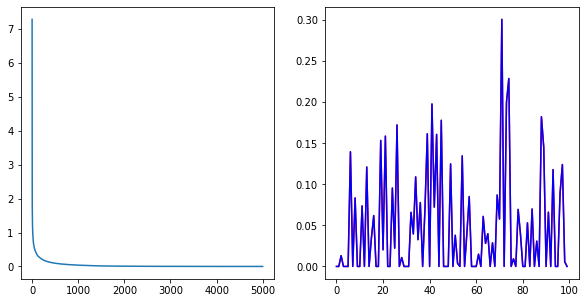

In [7]:
x,x_cvx,psnr_rec=mytest(constraint=True,maxit1=5000,rho1=50)

In [22]:
#1D sparse signal and its mearsurements
n = 100
N = n**2
Ncount = 1000
alpha = 5
s = 1 / (2 * alpha)
A = makeA2d(n)

spikes = 6
u = np.zeros((N,1))
k = np.random.randint(0,N-50,spikes)
u[k+25] = 50*np.random.rand(spikes,1)
#u = np.cumsum(u)
u = abs(u).reshape(N,1)
u[:60] = 0                      
u[-60:] = 0

#Fw = np.linalg.matrix_power(A, Ncount)
#meas = (Fw@u).reshape(N,1)
#noise = 1*np.random.randn(meas.shape[0],1)
#measn = meas + noise  

In [23]:
# linear filter
c = np.stack([np.linspace(0,30,30),np.linspace(30,0,30)],axis=1).T.reshape(60,1)
meas1 = np.copy(u)
for i in range(N-60):
    meas1[i+30] = u[i:(i+60)].T.dot(c)/sum(c)
meas1n = meas1 + 5*np.random.randn(meas1.shape[0],1)
# moving window filter
meas2 = np.copy(u)
for i in range(N-60):
    meas2[i+30] = np.mean(u[i:(i+60)])
meas2n = meas2 + 5*np.random.randn(meas2.shape[0],)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0cb8786a10>,
 [<matplotlib.lines.Line2D at 0x7f0cb848ff50>])

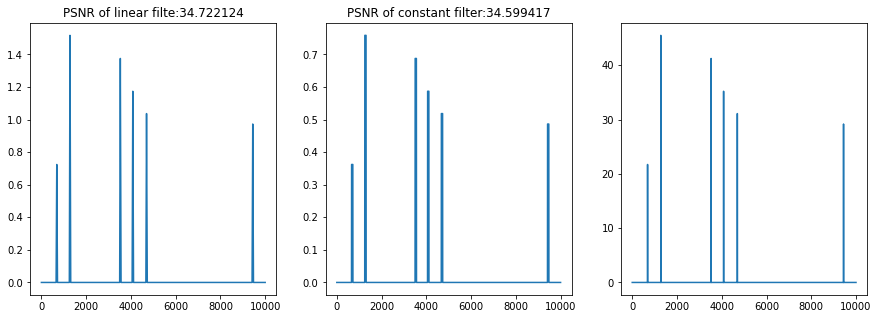

In [24]:
#plot signal and measurenments
plt.figure(figsize=(15,5))
plt.subplot(131),plt.plot(meas1),plt.title('PSNR of linear filte:{:f}'.format(psnr2(u,meas1)))
plt.subplot(132),plt.plot(meas2),plt.title('PSNR of constant filter:{:f}'.format(psnr2(u,meas2)))
plt.subplot(133),plt.plot(u)

In [33]:
t = np.linspace(1,1000,20)
a =[]
b =[]
Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A[0,:].toarray().reshape(N,))),0)
for ti in range(20):
    u_rec,err = myADMM(Sigma**(int(t[ti])),meas1,constrain=True,rho=1)
    mix_norm = np.linalg.norm((u_rec).reshape(N,), 0.5)**0.5 + 1e-2*(np.linalg.norm((u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(u,u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

iter 2459
N: 1.0 psnr 34.42566440366705 mixed norm: 257.6562098037809
N: 53.578947368421055 psnr 34.33714603523878 mixed norm: 284.97191692152614
N: 106.15789473684211 psnr 34.3181472166204 mixed norm: 248.96919013664467
N: 158.73684210526318 psnr 34.26983208790105 mixed norm: 216.15986359577147
N: 211.31578947368422 psnr 34.26983458214162 mixed norm: 207.39296511980965
N: 263.89473684210526 psnr 34.2066254988609 mixed norm: 179.4132304902725
N: 316.47368421052636 psnr 34.15930340768203 mixed norm: 169.75417351610318
N: 369.0526315789474 psnr 34.08054967099515 mixed norm: 159.39073100829893
N: 421.63157894736844 psnr 33.92458559401017 mixed norm: 138.54980170578213
N: 474.2105263157895 psnr 33.91076976537131 mixed norm: 138.52977736339457
N: 526.7894736842105 psnr 33.91649649038785 mixed norm: 143.42075579534497
N: 579.3684210526316 psnr 33.926485111054745 mixed norm: 141.27271813322835
N: 631.9473684210527 psnr 33.85171260101451 mixed norm: 135.83250570011623
N: 684.5263157894738 psnr

iter 2471
33.449816816040396


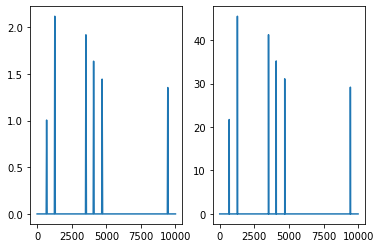

In [31]:
N_recon = np.round(t[a==np.min(a)])
x,err = myADMM(Sigma**(10),meas1,constrain=True,rho=1)
plt.subplot(121),plt.plot(x)
plt.subplot(122),plt.plot(u)
print(psnr_rec)